In [ ]:

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression


from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/ml_odev/air_quality_pm25.csv"

df = pd.read_csv(file_path)

df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [ ]:
print("Şekil:", df.shape)

print("\nKolonlar:")
print(df.columns)

print("\nInfo:")
print(df.info())

print("\nEksik değer sayıları:")
print(df.isna().sum())


Şekil: (43824, 13)

Kolonlar:
Index(['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES',
       'cbwd', 'Iws', 'Is', 'Ir'],
      dtype='object')

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB
None

Eksik değer sayıları:
No          0
year        0
month       0
day         0
hour        0
pm2.

In [ ]:
df.replace("NA", np.nan, inplace=True)

print(df.isna().sum())


No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64


In [ ]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

print("Sayısal kolonlar:", numeric_cols)
print("Kategorik kolonlar:", cat_cols)

for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("\nEksik veri sonrası kontrol:")
print(df.isna().sum())


Sayısal kolonlar: ['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']
Kategorik kolonlar: ['cbwd']

Eksik veri sonrası kontrol:
No       0
year     0
month    0
day      0
hour     0
pm2.5    0
DEWP     0
TEMP     0
PRES     0
cbwd     0
Iws      0
Is       0
Ir       0
dtype: int64


In [ ]:
df['datetime'] = pd.to_datetime(df[['year','month','day','hour']])

df[['datetime','pm2.5']].head()


,datetime,pm2.5
0,2010-01-01 00:00:00,72.0
1,2010-01-01 01:00:00,72.0
2,2010-01-01 02:00:00,72.0
3,2010-01-01 03:00:00,72.0
4,2010-01-01 04:00:00,72.0


In [ ]:
def remove_outliers_iqr(data, cols, factor=1.5):
    data_clean = data.copy()
    for col in cols:
        Q1 = data_clean[col].quantile(0.25)
        Q3 = data_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        # uçları kırpıyoruz (clip), tamamen atmak yerine daha yumuşak
        data_clean[col] = data_clean[col].clip(lower, upper)
    return data_clean

numeric_cols_no_target = [c for c in numeric_cols if c != 'pm2.5']
df_clean = remove_outliers_iqr(df, numeric_cols_no_target)

df_clean.describe()


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,datetime
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.0,43824.0,43824
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,97.357977,1.817246,12.448521,1016.447654,14.646504,0.0,0.0,2012-07-01 23:30:00
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.0,0.0,2010-01-01 00:00:00
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,31.000000,-10.000000,2.000000,1008.000000,1.790000,0.0,0.0,2011-04-02 11:45:00
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.0,0.0,2012-07-01 23:30:00
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,132.000000,15.000000,23.000000,1025.000000,21.910000,0.0,0.0,2013-10-01 11:15:00
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,52.090000,0.0,0.0,2014-12-31 23:00:00
std,12651.043435,1.413842,3.448572,8.799425,6.922266,90.030249,14.433440,12.198613,10.268698,17.551268,0.0,0.0,NaN


In [ ]:
target_col = 'pm2.5'

drop_cols = ['No', 'datetime'] if 'No' in df_clean.columns else ['datetime']

X = df_clean.drop(columns=[target_col] + drop_cols)
y = df_clean[target_col]

X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

X.head()


,year,month,day,hour,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv
0,2010,1,1,0,-21,-11.0,1021.0,1.79,0,0,True,False,False
1,2010,1,1,1,-21,-12.0,1020.0,4.92,0,0,True,False,False
2,2010,1,1,2,-21,-11.0,1019.0,6.71,0,0,True,False,False
3,2010,1,1,3,-21,-14.0,1019.0,9.84,0,0,True,False,False
4,2010,1,1,4,-20,-12.0,1018.0,12.97,0,0,True,False,False


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train şekil:", X_train.shape)
print("Test şekil:", X_test.shape)


Train şekil: (35059, 13)
Test şekil: (8765, 13)


In [ ]:
scaler = StandardScaler()

num_features = [col for col in X_train.columns if X_train[col].dtype != 'uint8']

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_features] = scaler.fit_transform(X_train[num_features])
X_test_scaled[num_features] = scaler.transform(X_test[num_features])


In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(RandomForestRegressor(n_estimators=200, random_state=42),
                            X_train_scaled, y_train,
                            scoring='r2', cv=5)

print("5-fold CV R2:", cv_scores.mean(), "+/-", cv_scores.std())

5-fold CV R2: 0.826854518422462 +/- 0.009868252806758052


In [ ]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    )
}

results = []

for name, model in models.items():
    print(f"\nModel: {name}")
    start = time.time()
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    end = time.time()

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    mse = mean_squared_error(y_test, y_pred)   # burada karekök almadan MSE
    rmse = np.sqrt(mse)                        # biz karekök alıyoruz

    duration = end - start

    print(f"R2   : {r2:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"Süre : {duration:.2f} sn")

    results.append({
        "Model": name,
        "R2": r2,
        "MAE": mae,
        "RMSE": rmse,
        "Süre_s": duration
    })

results_df = pd.DataFrame(results)
results_df



Model: LinearRegression
R2   : 0.2589
MAE  : 55.6668
RMSE : 76.8569
Süre : 0.02 sn

Model: RandomForest
R2   : 0.8471
MAE  : 21.5413
RMSE : 34.9146
Süre : 34.94 sn

Model: GradientBoosting
R2   : 0.5150
MAE  : 43.8204
RMSE : 62.1753
Süre : 8.98 sn


,Model,R2,MAE,RMSE,Süre_s
0,LinearRegression,0.258895,55.666850,76.856937,0.019313
1,RandomForest,0.847058,21.541309,34.914627,34.939034
2,GradientBoosting,0.514992,43.820379,62.175283,8.980796


In [ ]:
rf = models["RandomForest"]

importances_rf = rf.feature_importances_
feat_imp_rf = pd.Series(importances_rf, index=X_train_scaled.columns)

feat_imp_rf.sort_values(ascending=False).head(15)


,0
DEWP,0.247052
day,0.159221
month,0.130848
TEMP,0.122119
PRES,0.096656
Iws,0.085063
year,0.069225
hour,0.054659
cbwd_NW,0.022496
cbwd_SE,0.008852


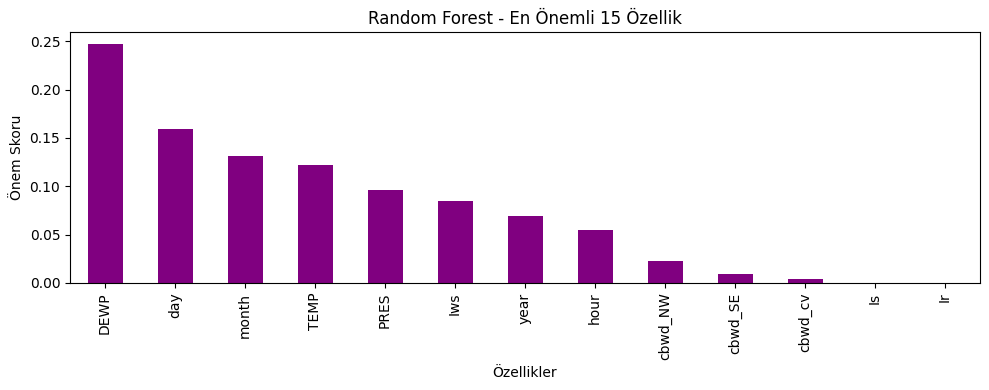

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
feat_imp_rf.sort_values(ascending=False).head(15).plot(kind="bar", color="purple")
plt.title("Random Forest - En Önemli 15 Özellik")
plt.ylabel("Önem Skoru")
plt.xlabel("Özellikler")
plt.tight_layout()
plt.show()



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_dist = {
    'n_estimators': randint(80, 180),
    'max_depth': [10, 20, None],
    'min_samples_split': randint(2, 6),
    'min_samples_leaf': randint(1, 3)
}

search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=8,
    cv=2,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

start = time.time()
search.fit(X_train_scaled, y_train)
end = time.time()

print("En iyi parametreler:", search.best_params_)
print("Toplam süre (sn):", end - start)


Fitting 2 folds for each of 8 candidates, totalling 16 fits
En iyi parametreler: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 179}
Toplam süre (sn): 180.77346301078796


In [ ]:
best_rf = search.best_estimator_

y_pred_best = best_rf.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred_best)
mae = mean_absolute_error(y_test, y_pred_best)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))

print("Tuned Random Forest Sonuçları")
print("R2:", r2)
print("MAE:", mae)
print("RMSE:", rmse)


Tuned Random Forest Sonuçları
R2: 0.8398281515554116
MAE: 22.216073585475797
RMSE: 35.73027980055321


In [ ]:
results_df.loc[len(results_df)] = [
    "RandomForest_Tuned",
    0.8398281515554116,
    22.216073585475797,
    35.73027980055321,
    200.0872   # toplam süreyi buraya yazıyoruz
]

results_df


,Model,R2,MAE,RMSE,Süre_s
0,LinearRegression,0.258895,55.666850,76.856937,0.019313
1,RandomForest,0.847058,21.541309,34.914627,34.939034
2,GradientBoosting,0.514992,43.820379,62.175283,8.980796
3,RandomForest_Tuned,0.839828,22.216074,35.730280,200.087200


In [ ]:
results_df.sort_values("RMSE")


,Model,R2,MAE,RMSE,Süre_s
1,RandomForest,0.847058,21.541309,34.914627,34.939034
3,RandomForest_Tuned,0.839828,22.216074,35.730280,200.087200
2,GradientBoosting,0.514992,43.820379,62.175283,8.980796
0,LinearRegression,0.258895,55.666850,76.856937,0.019313


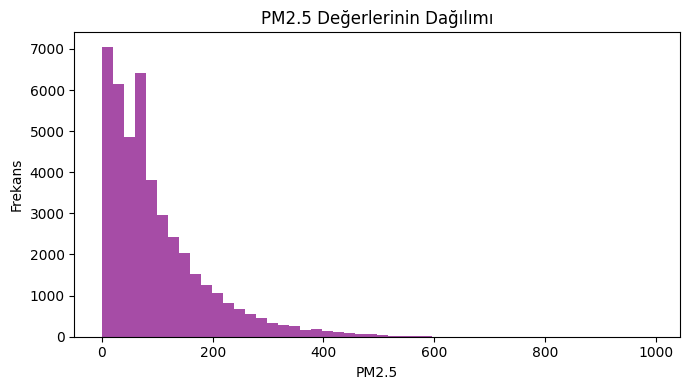

In [ ]:
plt.figure(figsize=(7,4))
plt.hist(df_clean['pm2.5'], bins=50, color="purple", alpha=0.7)
plt.title("PM2.5 Değerlerinin Dağılımı")
plt.xlabel("PM2.5")
plt.ylabel("Frekans")
plt.tight_layout()
plt.show()


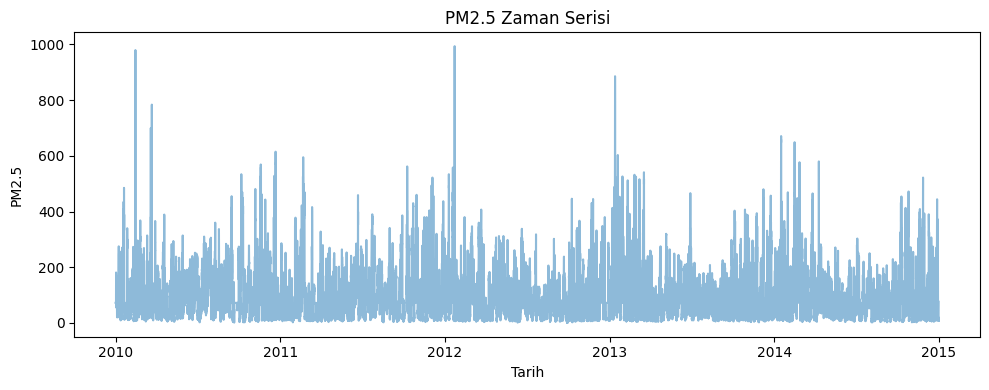

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df_clean['datetime'], df_clean['pm2.5'], alpha=0.5)
plt.title("PM2.5 Zaman Serisi")
plt.xlabel("Tarih")
plt.ylabel("PM2.5")
plt.tight_layout()
plt.show()


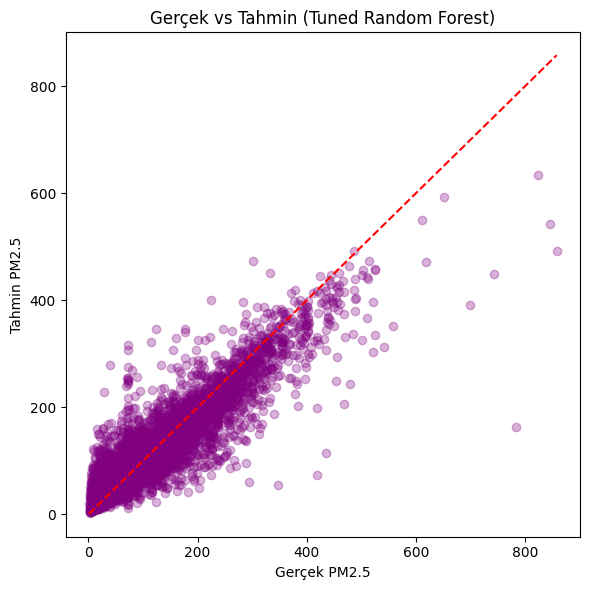

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_best, alpha=0.3, color="purple")
plt.xlabel("Gerçek PM2.5")
plt.ylabel("Tahmin PM2.5")
plt.title("Gerçek vs Tahmin (Tuned Random Forest)")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.tight_layout()
plt.show()


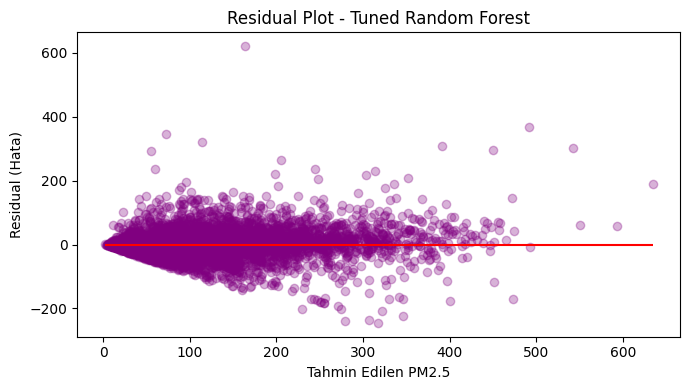

In [ ]:
residuals = y_test - y_pred_best

plt.figure(figsize=(7,4))
plt.scatter(y_pred_best, residuals, alpha=0.3, color="purple")
plt.hlines(0, y_pred_best.min(), y_pred_best.max(), colors="red")
plt.xlabel("Tahmin Edilen PM2.5")
plt.ylabel("Residual (Hata)")
plt.title("Residual Plot - Tuned Random Forest")
plt.tight_layout()
plt.show()


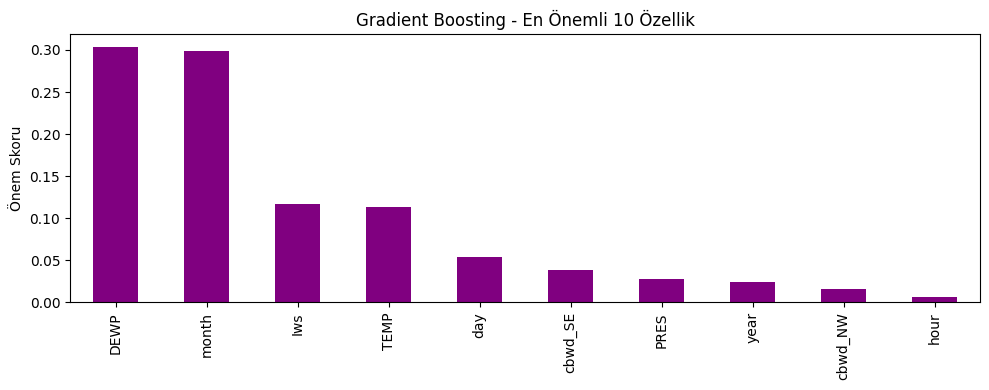

In [ ]:
gb = models["GradientBoosting"]
feat_imp_gb = pd.Series(gb.feature_importances_, index=X_train_scaled.columns)

plt.figure(figsize=(10,4))
feat_imp_gb.sort_values(ascending=False).head(10).plot(kind="bar", color="purple")
plt.title("Gradient Boosting - En Önemli 10 Özellik")
plt.ylabel("Önem Skoru")
plt.tight_layout()
plt.show()


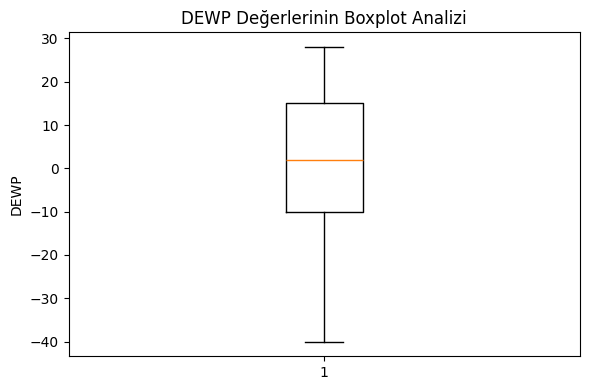

In [ ]:
plt.figure(figsize=(6,4))
plt.boxplot(df_clean['DEWP'])
plt.title("DEWP Değerlerinin Boxplot Analizi")
plt.ylabel("DEWP")
plt.tight_layout()
plt.show()


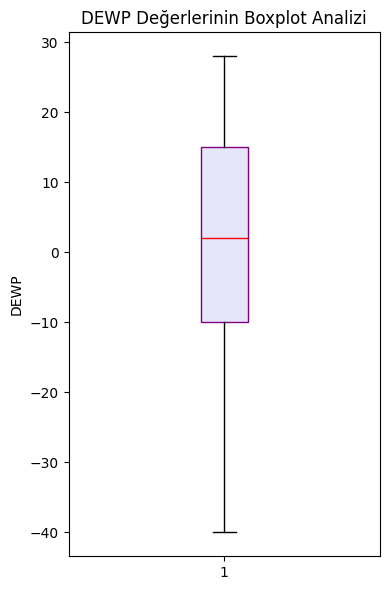

In [ ]:
plt.figure(figsize=(4,6))
plt.boxplot(df_clean['DEWP'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lavender', color='purple'),
            medianprops=dict(color='red'))
plt.title("DEWP Değerlerinin Boxplot Analizi")
plt.ylabel("DEWP")
plt.tight_layout()
plt.show()


In [ ]:
!pip install shap
import shap


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    )
}


In [ ]:
best_model = models["RandomForest"]
best_model.fit(X_train_scaled, y_train)


RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [ ]:
import shap

best_model = models["RandomForest"]

X_sample = X_test_scaled.sample(600, random_state=42)

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_sample)


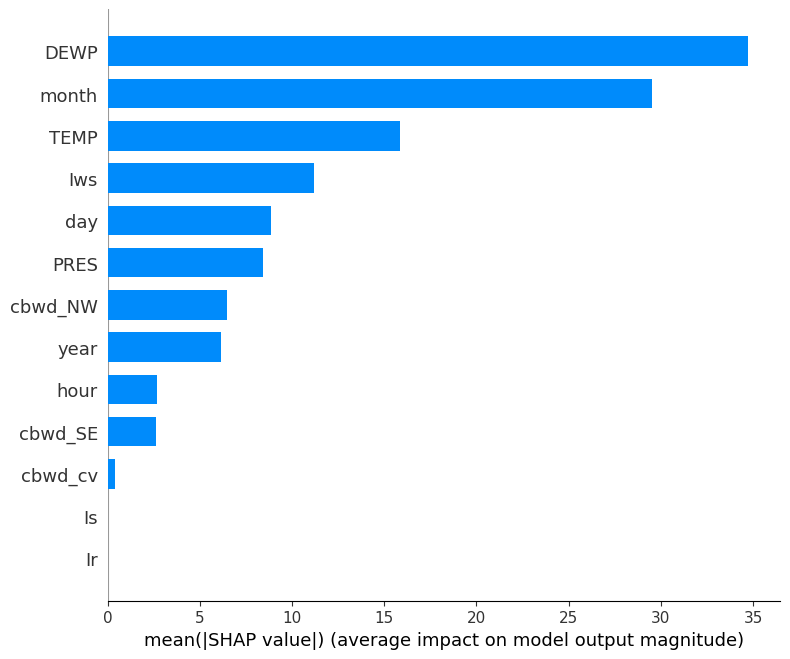

In [ ]:
shap.summary_plot(shap_values, X_sample, plot_type="bar")


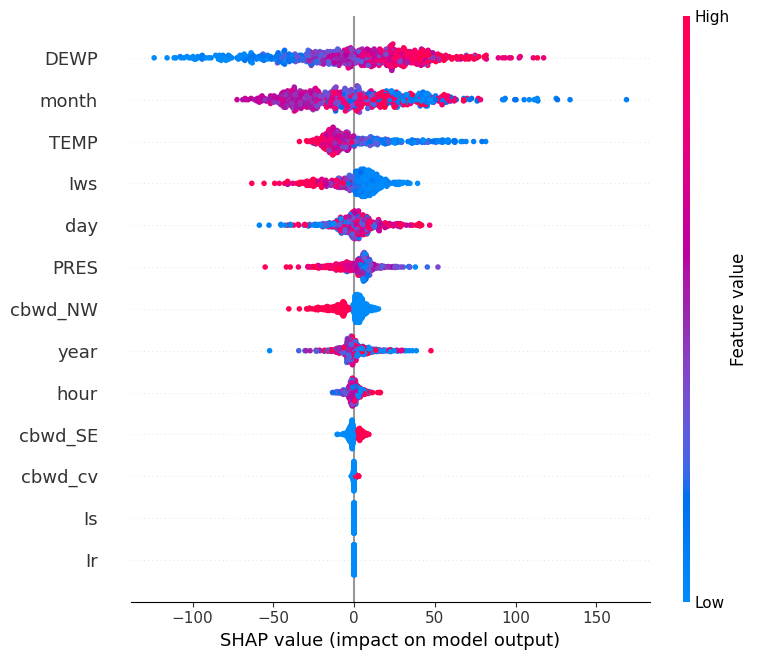

In [ ]:
shap.summary_plot(shap_values, X_sample)


In [ ]:
import time
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

models_timing = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.05,
                                                  max_depth=3, random_state=42)
}

timing_results = []

for name, model in models_timing.items():
    start = time.time()
    model.fit(X_train_scaled, y_train)
    end = time.time()

    duration = end - start
    timing_results.append([name, round(duration, 3)])

import pandas as pd
timing_df = pd.DataFrame(timing_results, columns=["Model", "Çalışma Süresi (sn)"])
timing_df


,Model,Çalışma Süresi (sn)
0,LinearRegression,0.275
1,RandomForest,49.649
2,GradientBoosting,8.966
